# Deep Generative Models for Representation Learning

In this tutorial, we will explore different types of deep generative models and how we can use them for representation learning. As a simple benchmark, we will train them on the [MNIST data set](http://yann.lecun.com/exdb/mnist/) and evaluate them using different techniques.

Make sure to switch the runtime backend to `GPU` to improve the speed of the computations.

Throughout the code, you will find `#TODO` comments that suggest further exploration of the code and the implementation of additional pieces.

But first, we need to load some packages.

In [1]:
import os

import numpy as np
from tqdm.auto import trange
import torch
import torch.distributions as td
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(12345)
torch.manual_seed(12345)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

sns.set(context="paper", style="white", font_scale=1.5)
%matplotlib inline

## Load MNIST data

Now we can make a directory for our data and then load it from `torchvision`. We will flatten the 28x28 pixel images into 784-dimensional vectors, so that we can easily train fully-connected networks on them.

In [2]:
os.makedirs("data", exist_ok=True)

In [ ]:
transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Lambda(lambd=torch.flatten)
                             ])

mnist_train = torchvision.datasets.MNIST(root="data", download=True, transform=transform, train=True)
mnist_test = torchvision.datasets.MNIST(root="data", download=True, transform=transform, train=False)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


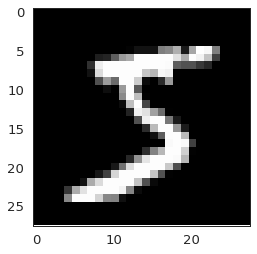

In [ ]:
plt.imshow(mnist_train.data[0], cmap="gray");

With our freshly loaded data, we can then generate PyTorch data loaders, which we can later use to easily train and test our models.

In [ ]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=1)

## Build autoencoder model

The first model we are going to look at is a simple [autoencoder](https://proceedings.neurips.cc/paper/2006/file/5da713a690c067105aeb2fae32403405-Paper.pdf). This neural network just tries to learn the identity function, but it contains a bottleneck layer in the middle which is lower-dimensional than the input. It thus needs to learn to compress the data into low-dimensional representations.

We are first going to define the encoder network, which maps from the data space into the lower-dimensional latent space.

In [ ]:
class Encoder(nn.Module):
    """Simple feedforward encoder network."""
    def __init__(self, input_dim=784, latent_dim=16, width=512):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, width)
        self.layer2 = nn.Linear(width, width)
        self.layer3 = nn.Linear(width, latent_dim)
        
    def forward(self, x):
        out = self.layer1(x)
        out = F.relu(out)
        out = self.layer2(out)
        out = F.relu(out)
        out = self.layer3(out)
        return out

Then we can define the decoder, which is just a mirrored version of the encoder.

In [ ]:
class Decoder(Encoder):
    """Simple feedforward decoder network."""
    def __init__(self, output_dim=784, latent_dim=16, width=512):
        super().__init__(input_dim=latent_dim, width=width, latent_dim=output_dim)

And finally we can put them both together into the autoencoder architecture.

In [ ]:
class Autoencoder(nn.Module):
    """A simple feedforward autoencoder."""
    def __init__(self, data_dim=784, latent_dim=16, width=512):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=data_dim, latent_dim=latent_dim, width=width)
        self.decoder = Decoder(output_dim=data_dim, latent_dim=latent_dim, width=width)
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return torch.sigmoid(self.decoder(z))
        
    def forward(self, x, return_latent=False):
        z = self.encode(x)
        x_hat = self.decode(z)
        if return_latent:
            return x_hat, z
        else:
            return x_hat

## Train autoencoder on MNIST

Now that we have defined the model architecture, we can try to train it on MNIST.

In [ ]:
num_epochs = 40    # TODO: try training for longer
learning_rate = 5e-4    # TODO: try different learning rates
print_interval = 100

In [ ]:
ae_model = Autoencoder().to(device)    # TODO: try a different width or latent_dim

We will use the mean squared error loss to measure the reconstruction quality.

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(ae_model.parameters(), lr=learning_rate)

We can now train the model with our defined optimizer, while keeping track of the reconstruction loss.

In [ ]:
pbar = trange(num_epochs)
for epoch in pbar:
    for i, (x_batch, _) in enumerate(trainloader):
        x_batch = x_batch.to(device)
        ae_model.zero_grad()
        x_hat = ae_model(x_batch)
        loss = loss_fn(x_batch, x_hat)
        loss.backward()
        optimizer.step()
        
        if i % print_interval == 0:
            pbar.set_postfix_str(f"loss = {loss.item():.3f}")

## Evaluate AE model

In order to evaluate our model, one thing we can do is to just encode and decode images from the MNIST test set and assess how well the model reconstructs them. Keep in mind that the original data vectors are 784-dimensional and our model has to pass that information through a much lower-dimensional latent space, so we don't expect the reconstructions to be perfect.

In [ ]:
def plot_reconstructions(model, x_batch):
    """Plot the images in x_batch and their reconstructions using the model."""
    x_rec = model(x_batch).cpu().detach().numpy().reshape(-1,28,28)
    x_in = x_batch.cpu().numpy().reshape(-1,28,28)
    num_imgs = len(x_in)

    fig, axes = plt.subplots(nrows=2, ncols=num_imgs, figsize=(num_imgs, 2))

    for i in range(num_imgs):
        axes[0,i].imshow(x_in[i], cmap="gray")
        axes[1,i].imshow(x_rec[i], cmap="gray")
        axes[0,i].axis("off")
        axes[1,i].axis("off")
    
    return fig

In [ ]:
x_batch, _ = next(iter(testloader))
x_batch = x_batch.to(device)

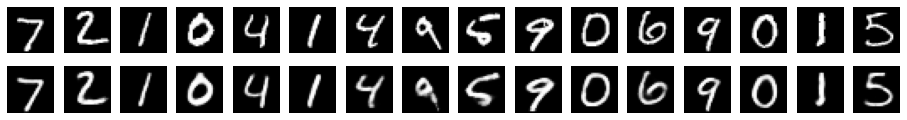

In [ ]:
plot_reconstructions(ae_model, x_batch[:16]);

It seems like our reconstructions look pretty decent. This is also confirmed by the low reconstruction loss on the test set:

In [ ]:
losses = []
for x_batch, _ in testloader:
    x_batch = x_batch.to(device)
    losses.append(loss_fn(x_batch, ae_model(x_batch)).cpu().item())
print(f"MSE loss on test set = {np.mean(losses):.3f}")

MSE loss on test set = 0.008


## Inspect latent space

Now that we have convinced ourselves that the model is able to reconstruct unseen data well and therefore seems to have captured some useful information in the latent representations, we can try to get an intuition for what these representations look like. We can do this by comparing a 2D [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) of the raw data and the representations.

In [ ]:
def plot_pca(data, latents, labels):
    pca = PCA(n_components=2)

    mnist_data_pca = pca.fit_transform(data)
    variance_explained_data = pca.explained_variance_ratio_

    mnist_latent_pca = pca.fit_transform(latents)
    variance_explained_latent = pca.explained_variance_ratio_

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    sns.scatterplot(ax=axes[0], x=mnist_data_pca[:,0], y=mnist_data_pca[:,1], hue=labels)
    sns.scatterplot(ax=axes[1], x=mnist_latent_pca[:,0], y=mnist_latent_pca[:,1], hue=labels)

    axes[0].set_xlabel(f"PC 1 ({variance_explained_data[0]*100:.1f}% variance)")
    axes[0].set_ylabel(f"PC 2 ({variance_explained_data[1]*100:.1f}% variance)")
    axes[1].set_xlabel(f"PC 1 ({variance_explained_latent[0]*100:.1f}% variance)")
    axes[1].set_ylabel(f"PC 2 ({variance_explained_latent[1]*100:.1f}% variance)")

    axes[0].set_title("Data space")
    axes[1].set_title("Latent space")

    fig.tight_layout()
    return fig

In [ ]:
mnist_representations_ae = []
for x_batch, _ in testloader:
    x_batch = x_batch.to(device)
    _, z = ae_model(x_batch, return_latent=True)
    mnist_representations_ae.append(z.cpu())
mnist_representations_ae = torch.cat(mnist_representations_ae).detach().numpy()

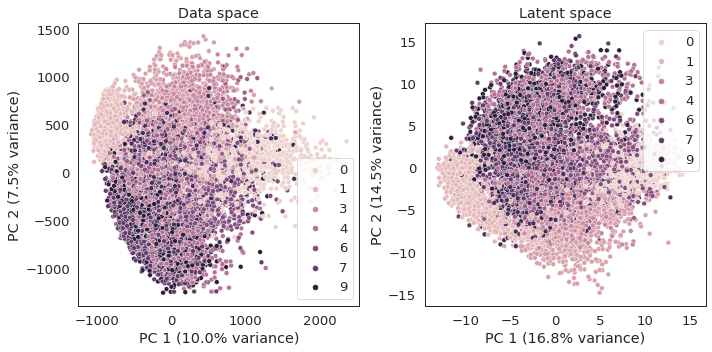

In [ ]:
plot_pca(data=testloader.dataset.data.reshape(-1, 784).numpy(),
         latents=mnist_representations_ae,
         labels=testloader.dataset.targets.numpy());

The points in the PCA here are colored by their respective class labels. What do you think of the representations in the latent space compared to the data space? Note also the amount of variance explained by the respective principal components.

## Build variational autoencoder model

One way to encourage our model to learn a more structured latent space is to use a [variational autoencoder](https://arxiv.org/abs/1312.6114). This model does not encode data points deterministically, but stochastically. Moreover, it comes with a prior on the distribution of the latent representations (usually a standard Gaussian) and then optimizes not only the reconstruction error (or respectively, the likelihood of the generated data), but also the KL divergence between the latent distribution of the encoded data and the prior.

The objective function is the evidence lower bound (ELBO): $$ \text{ELBO} = \mathbb{E}_q[\log p(x | z)] - D_{KL}(q(z|x) \| p(z)) \leq \log p(x)$$

Since we want to maximize this bound, but our PyTorch optimizers normally minimize the objective, we will use the negative ELBO as our loss function.

In [ ]:
class VariationalAutoencoder(nn.Module):
    """A simple feedforward variational autoencoder."""
    def __init__(self, data_dim=784, latent_dim=16, width=512, beta=1.):
        super().__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = Encoder(input_dim=data_dim, latent_dim=latent_dim*2, width=width)
        self.decoder = Decoder(output_dim=data_dim, latent_dim=latent_dim, width=width)
        
    def encode(self, x):
        encoding = self.encoder(x).view(-1, 2, self.latent_dim)
        mean, log_var = encoding[:,0,:], encoding[:,1,:]
        return mean, log_var
    
    def decode(self, z):
        reconstruction = torch.sigmoid(self.decoder(z))
        return reconstruction
    
    def sample_z(self, z_mean, z_logvar):
        # this is the famous reparameterization trick
        z_std = torch.exp(0.5*z_logvar)
        eps = torch.randn_like(z_std)
        z = z_mean + (z_std * eps)
        return z
        
    def forward(self, x, return_dist=False):
        z_mean, z_logvar = self.encode(x)
        z = self.sample_z(z_mean, z_logvar)
        x_hat = self.decode(z)
        if return_dist:
            return x_hat, z_mean, z_logvar
        else:
            return x_hat
    
    def compute_elbo(self, x, return_loss_terms=False):
        batchsize = x.shape[0]
        output, z_mean, z_logvar = self.forward(x, return_dist=True)
        likelihood_fn = nn.BCELoss(reduction="sum")
        likelihood = likelihood_fn(output, x)
        kl_divergence = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
        elbo = likelihood + self.beta * kl_divergence
        elbo /= batchsize
        if return_loss_terms:
            return elbo, likelihood, kl_divergence
        else:
            return elbo

## Train VAE on MNIST

We can train this model on MNIST, as we did with the standard autoencoder before, and evaluate its respective performance.

In [ ]:
vae_model = VariationalAutoencoder().to(device)    # TODO: try a different width or latent_dim

In [ ]:
learning_rate = 5e-4    # TODO: try tuning the learning rate

In [ ]:
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

In [ ]:
pbar = trange(num_epochs)
for epoch in pbar:
    for i, (x_batch, _) in enumerate(trainloader):
        x_batch = x_batch.to(device)
        vae_model.zero_grad()
        loss = vae_model.compute_elbo(x_batch)
        loss.backward()
        optimizer.step()
        
        if i % print_interval == 0:
            pbar.set_postfix_str(f"loss = {loss.item():.3f}")

## Evaluate VAE model

In [ ]:
x_batch, _ = next(iter(testloader))
x_batch = x_batch.to(device)

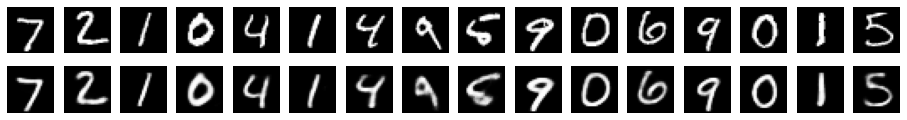

In [ ]:
plot_reconstructions(vae_model, x_batch[:16]);

We see that the reconstructions generally still look pretty good, although some of them are a bit more blurry. This is also reflected in the MSE:

In [ ]:
losses = []
for x_batch, _ in testloader:
    x_batch = x_batch.to(device)
    losses.append(loss_fn(x_batch, vae_model(x_batch)).item())
print(f"MSE loss on test set = {np.mean(losses):.3f}")

MSE loss on test set = 0.012


It is not surprising that the VAE has a slightly larger reconstruction error than the AE, since it does not only optimize the reconstruction error, but also the KL regularization term. This then yields a more Gaussian latent structure at the cost of some reconstruction quality.

In [ ]:
mnist_representations_vae = []
for x_batch, _ in testloader:
    x_batch = x_batch.to(device)
    _, z, _ = vae_model(x_batch, return_dist=True)
    mnist_representations_vae.append(z.cpu())
mnist_representations_vae = torch.cat(mnist_representations_vae).detach().numpy()

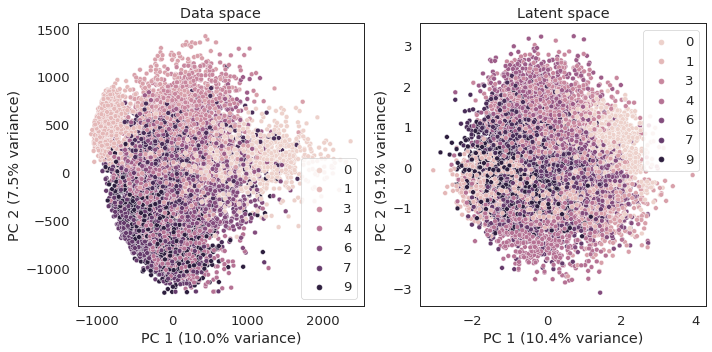

In [ ]:
plot_pca(data=testloader.dataset.data.reshape(-1, 784).numpy(),
         latents=mnist_representations_vae,
         labels=testloader.dataset.targets.numpy());

We also see that the latent distribution here looks more Gaussian than the one of the AE, due to the VAE's regularization term.

## Generate data samples from the latent space

Since the VAE contains a proper generative model, we can actually generate new samples from it. We do this by sampling latent representations from the (Gaussian) prior and then decoding them. Note that we can of course also try this for the previously trained AE model, but that we should not expect it to work very well, since that model had not been trained to distribute the latent representations as a Gaussian.

In [ ]:
def plot_generations(model, num_samples=16):
    """Plot num_samples images generated from the latent space using the model."""
    z_sample = torch.randn(num_samples, model.latent_dim).to(device)
    x_gen = model.decode(z_sample).cpu().detach().numpy().reshape(-1,28,28)

    fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(num_samples, 1))

    for i in range(num_samples):
        axes[i].imshow(x_gen[i], cmap="gray")
        axes[i].axis("off")
    
    return fig

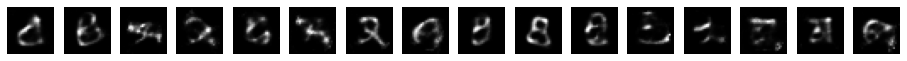

In [ ]:
plot_generations(ae_model);

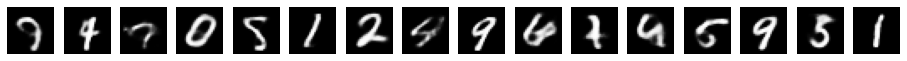

In [ ]:
plot_generations(vae_model);

As expected, we see that the generated images from the VAE look much more like real MNIST digits than the ones from the AE model.

## Evaluate disentanglement through latent traversals

As we saw, having normally distributed latents is very useful for sampling and generating. Another property that can be useful in latent distributions is _disentanglement_. This is generally meant to mean that different dimensions in the latent space encode different underlying factors of variation in the data.

Disentanglement is generally hard to measure and it might in fact be [impossible](https://arxiv.org/abs/1811.12359) to learn disentangled representations in an unsupervised way. However, one often-used way to get a qualitative intuition is to plot so-called [_latent traversals_](https://openreview.net/forum?id=Sy2fzU9gl), where we take a latent representation of a test image and modify single latent dimensions to see how the decoded image changes.

In [ ]:
def plot_latent_traversal(model, num_samples=16, basis_sample=None):
    """Plot traversals of each latent dimension of the model
    while holding the other dimensions fixed."""
    latent_dim = model.latent_dim
    if basis_sample is None:
        basis_sample = np.zeros(latent_dim)
    fig, axes = plt.subplots(nrows=latent_dim, ncols=num_samples, figsize=(num_samples, latent_dim))
    
    for dim, axs in enumerate(axes):
        z_sample = np.tile(basis_sample, (num_samples,1))
        z_sample[:,dim] = np.linspace(-3,3,num_samples)    # TODO: try to traverse more or less space
        z_sample = torch.from_numpy(z_sample).float().to(device)
        x_gen = model.decode(z_sample).cpu().detach().numpy().reshape(-1,28,28)
        for img, ax in zip(x_gen, axs):
            ax.imshow(img, cmap="gray")
            ax.axis("off")
            
    return fig

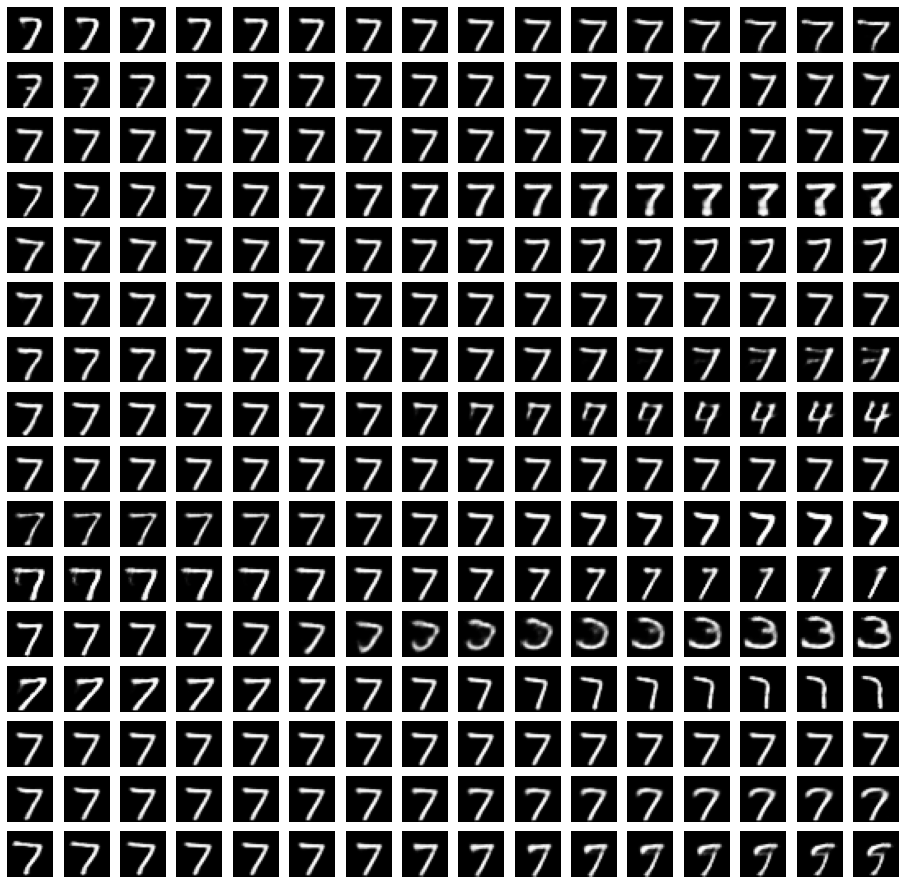

In [ ]:
x_batch, _ = next(iter(testloader))
x_batch = x_batch.to(device)
basis_sample = vae_model.encode(x_batch[:1])[0].cpu().detach().numpy()[0]
plot_latent_traversal(vae_model, basis_sample=basis_sample);

We see that in our standard VAE model, most latent dimensions do not seem to encode any interesting factors of variation.

## Train $\beta$-VAE model

A model that was proposed to improve the disentanglement of the latent representations is the [$\beta$-VAE](https://openreview.net/forum?id=Sy2fzU9gl). Instead of optimizing the actual ELBO, this model upweights the KL divergence term in the objective function by a factor $\beta > 1$, that is, $$ \text{ELBO}_{\beta} = \mathbb{E}_q[\log p(x | z)] - \beta D_{KL}(q(z|x) \| p(z)) $$

Note that the VAE model we defined above is in fact already a $\beta$-VAE, just with the default setting of $\beta = 1$. We can now try to set $\beta$ to a higher value and train the model again.

In [ ]:
betavae_model = VariationalAutoencoder(beta=4.).to(device)    # TODO: try different values of beta

In [ ]:
optimizer = torch.optim.Adam(betavae_model.parameters(), lr=learning_rate)

In [ ]:
pbar = trange(num_epochs)
for epoch in pbar:
    for i, (x_batch, _) in enumerate(trainloader):
        x_batch = x_batch.to(device)
        betavae_model.zero_grad()
        loss = betavae_model.compute_elbo(x_batch)
        loss.backward()
        optimizer.step()
        
        if i % print_interval == 0:
            pbar.set_postfix_str(f"loss = {loss.item():.3f}")

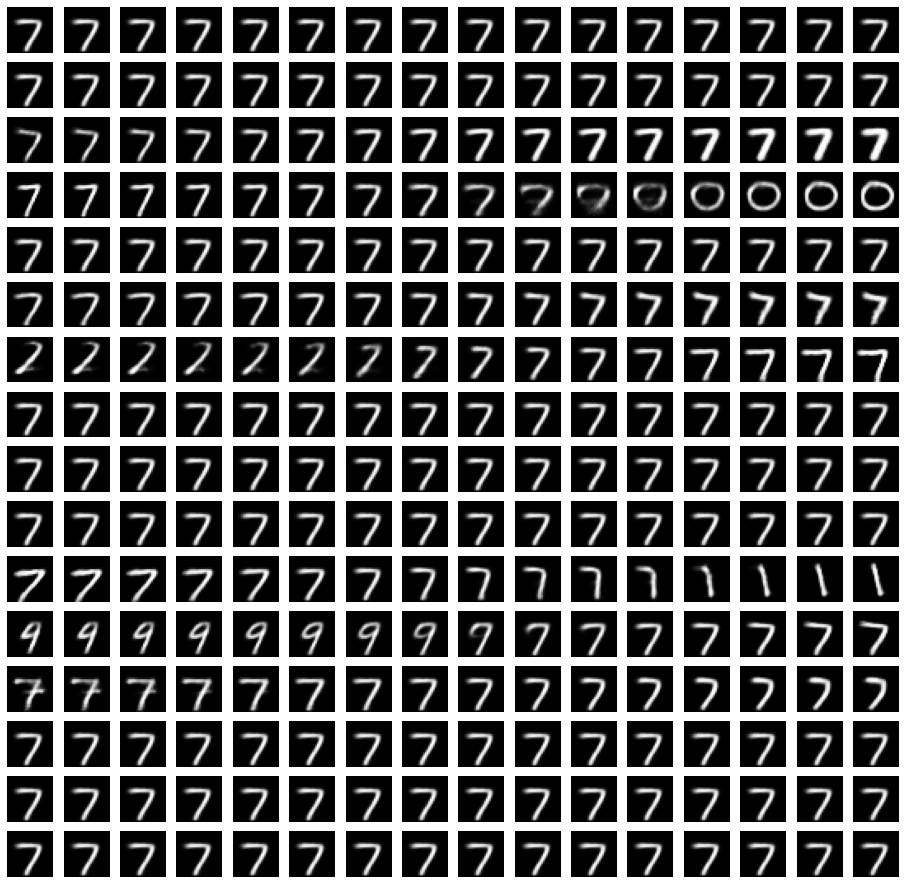

In [ ]:
x_batch, _ = next(iter(testloader))
x_batch = x_batch.to(device)
basis_sample = betavae_model.encode(x_batch[:1])[0].cpu().detach().numpy()[0]
plot_latent_traversal(betavae_model, basis_sample=basis_sample);

Do you feel that these representations are more disentangled than the ones from the VAE above? By which features would you judge that?

In [ ]:
# TODO: can you implement a better disentangled VAE model?
# maybe try FactorVAE (https://arxiv.org/abs/1802.05983)
# or beta-TCVAE (https://arxiv.org/abs/1802.04942)

## Build normalizing flow model

We have seen that all the models so far have learned a mapping from the data space to some latent space and a separate mapping from the latent space back to the data space. The encoder and decoder thus have to learn to approximately invert each other. If we are not satisfied with these approximations, we could instead try to use a function for the encoder that is exactly invertible, such that we do not need a separate decoder, but can just run the encoder backwards. One type of such models are [normalizing flows](https://arxiv.org/abs/1505.05770). Here, we can use a change of variables in the probability distributions, $$ p(x) = p(z) \, \left| \det \frac{\partial x}{\partial z} \right|^{-1} = p(z) \, \left| \det \frac{\partial z}{\partial x} \right| \, , $$ to optimize the log marginal likelihood directly instead of having to use a lower bound, that is, $$ \log p(x) = \log p(z) + \log \, \left| \det \frac{\partial z}{\partial x} \right| \, , $$ where the right term is the log-determinant of the Jacobian of the mapping from $x$ to $z$.

In this experiment, we will use a relatively simple type of normalizing flow, namely the [Real NVP](https://arxiv.org/abs/1605.08803). Note that in order to ensure exact invertibility, we cannot use a lower-dimensional latent space in these models, but have to use the same dimensionality in each layer. We first define a single invertible transformation.

In [ ]:
class InvertibleTransformation(nn.Module):
    """Single invertible transformation as a building block for our flow model.
    Adapted from https://github.com/gebob19/introduction_to_normalizing_flows/blob/master/normalizing_flows.ipynb
    """
    def __init__(self, input_dim, flip=False):
        assert input_dim % 2 == 0
        super().__init__()
        self.k = input_dim // 2
        self.flip = flip
        self.mu_net = nn.Sequential(nn.Linear(self.k, self.k),
                                   nn.Tanh(),
                                   nn.Linear(self.k, self.k))
        self.sigma_net = nn.Sequential(nn.Linear(self.k, self.k),
                                   nn.Tanh(),
                                   nn.Linear(self.k, self.k))
        

    def forward(self, x):
        x1, x2 = x[:, :self.k], x[:, self.k:]
        
        if self.flip:
            x1, x2 = x2, x1
            
        mu = self.mu_net(x1)
        sigma = self.sigma_net(x1)
        z1 = x1
        z2 = mu + (x2 * torch.exp(sigma))
        
        if self.flip:
            z1, z2 = z2, z1
        
        z = torch.cat([z1, z2], dim=-1)
        log_jacobian = sigma.sum(-1)
                
        return z, log_jacobian
    

    def inverse(self, z):
        z1, z2 = z[:, :self.k], z[:, self.k:]
        
        if self.flip:
            z1, z2 = z2, z1
            
        mu = self.mu_net(z1)
        sigma = self.sigma_net(z1)
        x1 = z1
        x2 = (z2 - mu) * torch.exp(-sigma)
        
        if self.flip:
            x1, x2 = x2, x1
            
        x = torch.cat([x1, x2], dim=-1)
        
        return x

We can then stack several of these invertible transformations to yield a more complex invertible function. Note that each transformation is relatively simple, such that we have to stack a few of them to reach a useful level of complexity.

In [ ]:
class FlowEncoder(nn.Module):
    """A normalizing flow made of stacked invertible transformations."""
    def __init__(self, input_dim=784, depth=6, logit_space=False):
        super().__init__()
        self.alpha = 0.1
        self.logit_space = logit_space
        self.prior = td.Normal(loc=0., scale=1.)
        self.transformations = nn.ModuleList(
                    [InvertibleTransformation(input_dim=input_dim, flip=(i%2))
                    for i in range(depth)])
        
    def forward(self, x):
        # for MNIST, we model the data in logit space
        if self.logit_space:
            x = x*(1.-self.alpha) + self.alpha*0.5
            x = torch.log(x) - torch.log(1-x)
        
        log_jacobian = 0.
        z = x
        
        for transform in self.transformations:
            z, log_jac = transform(z)
            log_jacobian += log_jac
            
        return z, log_jacobian
    
    def inverse(self, z):
        x = z
        
        for transform in self.transformations[::-1]:
            x = transform.inverse(x)
            
        if self.logit_space:
            x = torch.reciprocal(1 + torch.exp(-x))
            x = (x - (self.alpha*0.5)) / (1-self.alpha)
        
        return x
    
    def log_marginal_likelihood(self, x):
        z, log_jacobian = self.forward(x)
        log_prior = self.prior.log_prob(z)
        return log_prior.sum() + log_jacobian.sum()

Now we could in principle use the model, but for convenience we will wrap it into a class that follows the same API as our previous models.

In [ ]:
class FlowAutoencoder(nn.Module):
    """Simple wrapper for the FlowEncoder to follow the same API as our other models."""
    def __init__(self, input_dim=784, depth=20, logit_space=False):
        super().__init__()
        self.latent_dim = input_dim
        self.encoder = FlowEncoder(input_dim=input_dim,
                        depth=depth, logit_space=logit_space)
        
    def encode(self, x):
        z, _ = self.encoder(x)
        return z
    
    def decode(self, z):
        x = self.encoder.inverse(z)
        return x
    
    def forward(self, x):
        # since this model is invertible, it should always give perfect reconstructions
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat
    
    def mll_loss(self, x):
        batchsize = x.shape[0]
        mll = - (self.encoder.log_marginal_likelihood(x) 
                            / (batchsize * self.latent_dim))
        return mll

## Train flow on toy data

Before we apply our flow to the MNIST data, let's try it out on some simpler dataset first. We can use `sklearn`'s built-in functionality to generate the two moons dataset.

In [ ]:
moons_data, _ = make_moons(n_samples=1000, noise=0.1)

It looks like this:

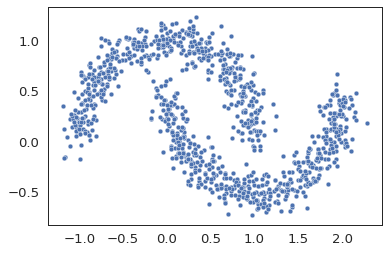

In [ ]:
sns.scatterplot(x=moons_data[:,0], y=moons_data[:,1]);

Now we can build a flow model and train it on the dataset. Note that here we perform full-batch gradient descent, so one gradient step is also one epoch. Hence, we need to use a rather large number of epochs.

In [ ]:
flow_model = FlowAutoencoder(input_dim=2, depth=10).to(device)    # TODO: try different depths

In [ ]:
num_epochs = 3000    # TODO: try training for longer
learning_rate = 1e-2    # TODO: try tuning the learning rate

In [ ]:
optimizer = torch.optim.Adam(flow_model.parameters(), lr=learning_rate)

In [ ]:
x_batch = torch.tensor(moons_data).float().to(device)

pbar = trange(num_epochs)
for epoch in pbar:
    
    flow_model.zero_grad()
    loss = flow_model.mll_loss(x_batch)
    loss.backward()
    optimizer.step()
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f}")

We can now use the trained model to encode the input data into the latent space.

In [ ]:
moons_representations_flow = flow_model.encode(x_batch).cpu().detach().numpy()

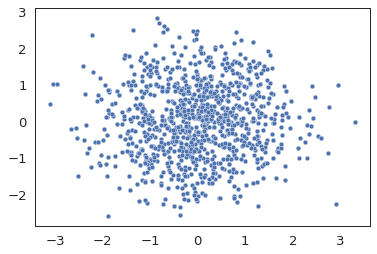

In [ ]:
sns.scatterplot(x=moons_representations_flow[:,0],
                y=moons_representations_flow[:,1]);

As expected, the latent distribution looks quite Gaussian. Conversely, we can also sample latent representations from a standard Gaussian and decode them into the data space.

In [ ]:
moons_generations = flow_model.decode(torch.tensor(np.random.normal(size=
                        moons_data.shape)).float().to(device)).cpu().detach().numpy()

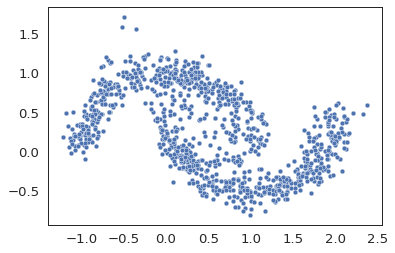

In [ ]:
sns.scatterplot(x=moons_generations[:,0],
                y=moons_generations[:,1]);

As also expected, these generations look rather similar to the original two moons dataset. After we have now convinced ourselves that the model works in principle, we can try to apply it to MNIST.

## Train flow on MNIST

Since this flow model has more parameters and is deeper than our previous models, the training will also take a bit longer.

In [ ]:
flow_model = FlowAutoencoder(depth=10, logit_space=True).to(device)    # TODO: try different depths

In [ ]:
num_epochs = 40    # TODO: try training for longer
learning_rate = 2e-5    # TODO: try tuning the learning rate

In [ ]:
optimizer = torch.optim.Adam(flow_model.parameters(), lr=learning_rate)

In [ ]:
pbar = trange(num_epochs)
for epoch in pbar:
    for i, (x_batch, _) in enumerate(trainloader):
        x_batch = x_batch.to(device)
        flow_model.zero_grad()
        loss = flow_model.mll_loss(x_batch)
        loss.backward()
        optimizer.step()
        
        if i % print_interval == 0:
            pbar.set_postfix_str(f"loss = {loss.item():.3f}")

## Evaluate flow model

In [ ]:
x_batch, _ = next(iter(testloader))
x_batch = x_batch.to(device)

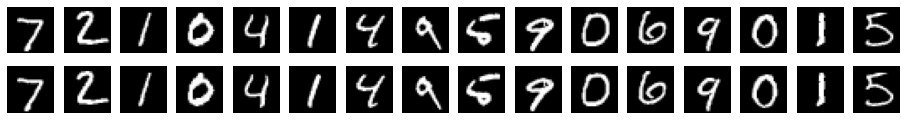

In [ ]:
plot_reconstructions(flow_model, x_batch[:16]);

In [ ]:
losses = []
for x_batch, _ in testloader:
    x_batch = x_batch.to(device)
    losses.append(loss_fn(x_batch, flow_model(x_batch)).item())
print(f"MSE loss on test set = {np.mean(losses):.3f}")

MSE loss on test set = 0.000


Expectedly, the reconstructions from this model are perfect, since the encoder and decoder are exact inverses of each other.

In [ ]:
mnist_representations_flow = []
for x_batch, _ in testloader:
    x_batch = x_batch.to(device)
    z = flow_model.encode(x_batch)
    mnist_representations_flow.append(z.cpu())
mnist_representations_flow = torch.cat(mnist_representations_flow).detach().numpy()

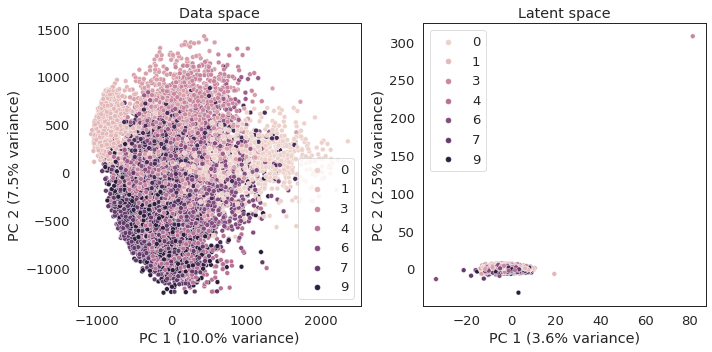

In [ ]:
plot_pca(data=testloader.dataset.data.reshape(-1, 784).numpy(),
         latents=mnist_representations_flow,
         labels=testloader.dataset.targets.numpy());

However, the latent representations look a bit different from the VAE. Do they look better or worse?

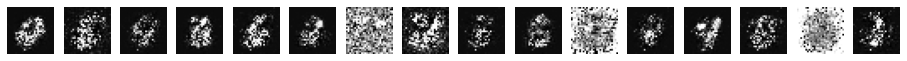

In [ ]:
plot_generations(flow_model);

Also, the generations do not seem to look as nice as for the VAE. This could be due to the limited expressive power of our used invertible transformations.

In [ ]:
# TODO: can you improve the performance of this flow model?
# maybe by changing the architecture or training it differently?

In [ ]:
# TODO: can you implement a better normalizing flow model?
# maybe try IAF (https://arxiv.org/abs/1606.04934)
# or MAF (https://arxiv.org/abs/1705.07057)

## Evaluate the representations on downstream tasks

Now that we have learned representations of our MNIST test set using our different models, it is time to see whether they are useful for downstream tasks. In this example, we will consider the task of k-means clustering.

In [ ]:
kmeans = KMeans(n_clusters=10)

In [ ]:
clusters_data = kmeans.fit_predict(testloader.dataset.data.reshape(-1,784))
clusters_ae = kmeans.fit_predict(mnist_representations_ae)
clusters_vae = kmeans.fit_predict(mnist_representations_vae)
clusters_flow = kmeans.fit_predict(mnist_representations_flow)

After having predicted the clusters, we can see whether the cluster assignment fits the ground-truth labels by computing the [normalized mutual information](https://en.wikipedia.org/wiki/Mutual_information#Normalized_variants) between them.

In [ ]:
labels = testloader.dataset.targets

print(f"NMI for clustering in data space = {normalized_mutual_info_score(labels, clusters_data):.3f}")
print(f"NMI for clustering in AE latent space = {normalized_mutual_info_score(labels, clusters_ae):.3f}")
print(f"NMI for clustering in VAE latent space = {normalized_mutual_info_score(labels, clusters_vae):.3f}")
print(f"NMI for clustering in flow latent space = {normalized_mutual_info_score(labels, clusters_flow):.3f}")

NMI for clustering in data space = 0.502
NMI for clustering in AE latent space = 0.641
NMI for clustering in VAE latent space = 0.644
NMI for clustering in flow latent space = 0.374


We see that at least the AE and VAE learn representations that are easier to cluster than the original data. The flow model, however, does not seem to help with that yet, which also fits to our observation that it is not generating very well.

In [ ]:
# TODO: can you think of any other downstream tasks on which we could use our representations?
# maybe try linear classification (https://en.wikipedia.org/wiki/Support_vector_machine#Linear_SVM)
# or semi-supervised learning (https://en.wikipedia.org/wiki/Semi-supervised_learning)